In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='-1'

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

In [5]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [6]:
import pathlib
# Train Data
data_dir = pathlib.Path('hotdog_data/train/')

hotdog_train = pathlib.Path('hotdog_data/train/hotdog/')
nothotdog_train = pathlib.Path('hotdog_data/train/nothotdog/')

In [7]:
# Count total pictures on the train folder
print(f'Number of Pictures on train folder (HotDog) {len(os.listdir(hotdog_train))}')
# Count total pictures on the test folder
print(f'Number of Pictures on train folder (NotHotDog) {len(os.listdir(nothotdog_train))}')

Number of Pictures on train folder (HotDog) 1500
Number of Pictures on train folder (NotHotDog) 1500


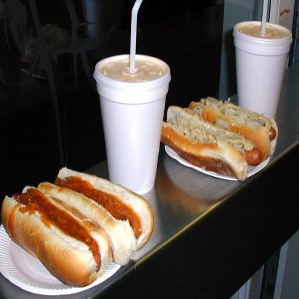

In [8]:
from IPython.display import display # to display images
pil_im = PIL.Image.open('hotdog_data/train/hotdog/102.jpg')
display(pil_im)

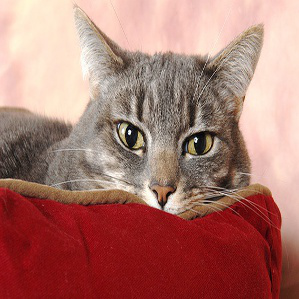

In [9]:
# Display one of the nothotdog images
pil_im = PIL.Image.open('hotdog_data/train/nothotdog/4.jpg')
display(pil_im)

Load images using <strong>image_dataset_from_directory()</strong> utility.

In [10]:
# Define Loader Parameters
batch_size = 32
img_height = 180
img_width = 180

In [11]:
# Create a training Subset
# Use a Validatation split of 20%
#CODE HERE use image_dataset_from_directory()
batch_ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    validation_split=.2,
    subset='training',
    seed=1337)
batch_ds_train

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [12]:
# Create a Validation Subset
# Use a Validatation split of 20%
#CODE HERE use image_dataset_from_directory()
batch_ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    validation_split=.2,
    subset='validation',
    seed=1337)
batch_ds_val

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

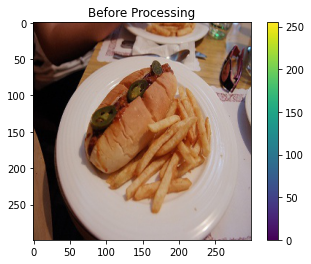

In [14]:
# Read Data
import glob
import matplotlib.image as mpimg
fun_data_dir = pathlib.Path('fun_data/')
foods = list(fun_data_dir.glob('*.jpg'))
img = mpimg.imread(foods[1])
plt.imshow(img)
plt.title("Before Processing")

plt.colorbar()
plt.grid(False)
plt.show()

#PIL.Image.open(str(foods[1]))
#nl = layers.experimental.preprocessing.Rescaling(1./255)
#one_food = PIL.Image.open(str(foods[1]))

#image_tensor = tf.convert_to_tensor(one_food, dtype=tf.float32)
#display(type(( nl(one_food))))


In [15]:
# Print class names for the training subset
#CODE HERE
batch_ds_train.class_names

['hotdog', 'nothotdog']

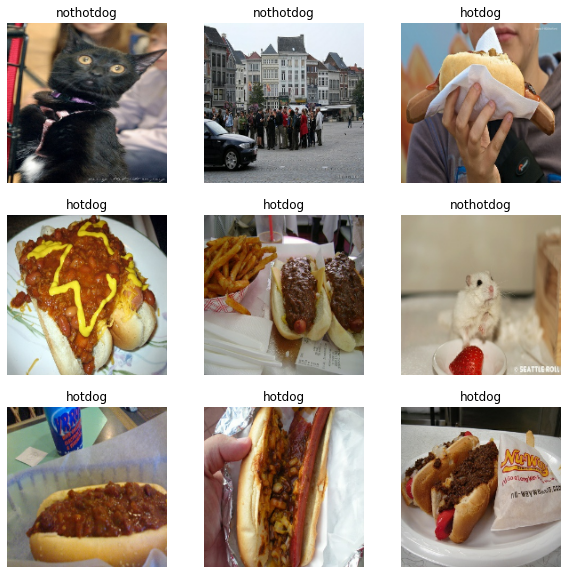

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in batch_ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(batch_ds_train.class_names[labels[i]])
    plt.axis("off")

In [17]:
# Configure Dataset Performance
AUTOTUNE = tf.data.AUTOTUNE

batch_ds_train = batch_ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
batch_ds_val = batch_ds_val.cache().prefetch(buffer_size=AUTOTUNE)

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [18]:
# Standardize the data
# Create a normalization Layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [19]:
# Apply normalization layer to the dataset by calling map.
# Hint: lambda function
normalized_ds = batch_ds_train.map(lambda x, y: (normalization_layer(x), y))
display(type(normalized_ds))
image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


tensorflow.python.data.ops.dataset_ops.MapDataset

0.0 0.9640024


In [20]:
# Create the model
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
# Compile the mode
# use the adam optimizer
# for loses uses losses.SparseCategoricalCrossentropy 
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [22]:
# Model Summary
# Depending on yout model it can be something different
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [23]:
# Train Model
# CODE HERE
model.fit(
    batch_ds_train,
    validation_data=batch_ds_val,
    epochs=10,
    verbose=1
)

Epoch 1/10
75/75 [==============================] - 15s 191ms/step - loss: 0.7738 - accuracy: 0.5583 - val_loss: 0.6342 - val_accuracy: 0.6283
Epoch 2/10
75/75 [==============================] - 14s 180ms/step - loss: 0.6167 - accuracy: 0.6633 - val_loss: 0.6480 - val_accuracy: 0.6150
Epoch 3/10
75/75 [==============================] - 14s 184ms/step - loss: 0.5628 - accuracy: 0.7029 - val_loss: 0.6378 - val_accuracy: 0.6483
Epoch 4/10
75/75 [==============================] - 14s 186ms/step - loss: 0.4958 - accuracy: 0.7538 - val_loss: 0.6424 - val_accuracy: 0.6517
Epoch 5/10
75/75 [==============================] - 14s 185ms/step - loss: 0.4188 - accuracy: 0.8092 - val_loss: 0.6533 - val_accuracy: 0.6667
Epoch 6/10
75/75 [==============================] - 14s 181ms/step - loss: 0.3394 - accuracy: 0.8571 - val_loss: 0.7361 - val_accuracy: 0.6500
Epoch 7/10
75/75 [==============================] - 14s 192ms/step - loss: 0.2254 - accuracy: 0.9137 - val_loss: 0.9549 - val_accuracy: 0.6483

In [ ]:
model.history.history.keys()

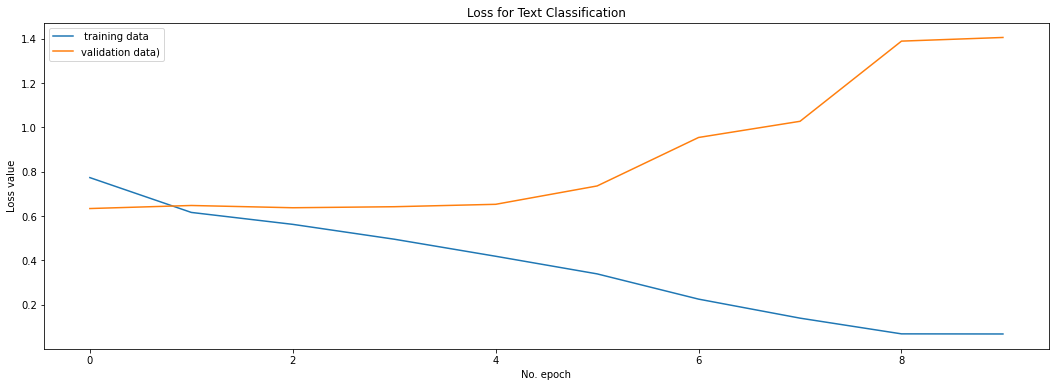

In [24]:
# Visaulize training loss and validation accuracy
# CODE HERE
#code here please
plt.figure(figsize=(18,6))
plt.plot(model.history.history['loss'], label=' training data')
plt.plot(model.history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left");

<strong>Is your model overfitted?</strong>

In [ ]:
# If so, consider Dropout


In [ ]:
# Compile and train the model


In [ ]:
# Visualize your new results


In [ ]:
# Predict on New Data
batch_ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'sample_test/',
    batch_size=batch_size,
    image_size=(img_height,img_width),
    validation_split=.2,
    subset='training',
    seed=1337)